In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(gridExtra)
library(DESeq2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.uns

###These files are from the [assign taxonomy](./Assign_taxonomy.ipynb), [tree](./Tree.ipynb), and [merge mappers](./demultiplex_QC/Merge_mappers.ipynb) notebooks.

In [4]:
%%R
#asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

head(physeq.md)

Sample Data:        [6 samples by 11 sample variables]:
                           Sample FractionNum Treatment Day Density Bulk
12C.700.45.01.24 12C.700.45.01.24          24    12C700  45  1.6783    0
12C.700.14.06.14 12C.700.14.06.14          14    12C700  14  1.7122    0
12C.100.14.05.18 12C.100.14.05.18          18    12C100  14  1.6980    0
12C.700.14.06.05 12C.700.14.06.05           5    12C700  14  1.7559    0
12C.000.14.05.18 12C.000.14.05.18          18      12CC  14  1.6936    0
12C.100.14.05.11 12C.100.14.05.11          11    12C100  14  1.7253    0
                 Control CC X100 X700 H2O
12C.700.45.01.24       1  0    0    1   0
12C.700.14.06.14       1  0    0    1   0
12C.100.14.05.18       1  0    1    0   0
12C.700.14.06.05       1  0    0    1   0
12C.000.14.05.18       1  1    0    0   0
12C.100.14.05.11       1  0    1    0   0


In [5]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.100 = prune_samples((physeq.md$Treatment %in% c("12C100","13C100")) &
                            (physeq.md$Bulk == "1"),
                            physeq) 

physeq.bulk.100 = filter_taxa(physeq.bulk.100, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.100

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5240 taxa and 11 samples ]
sample_data() Sample Data:       [ 11 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 5240 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 5240 tips and 5239 internal nodes ]


In [6]:
%%R
colnames(sample_data(physeq.bulk.100))

 [1] "Sample"      "FractionNum" "Treatment"   "Day"         "Density"    
 [6] "Bulk"        "Control"     "CC"          "X100"        "X700"       
[11] "H2O"        


In [7]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk.100, ~Day)
dds = DESeq(dds, fitType = "local")

r = results(dds, cooksCutoff = FALSE)
r$OTU = rownames(r)
r = data.frame(r)

TT = data.frame(tax_table(physeq.bulk.100))
TT$OTU = rownames(TT)

r = left_join(r, TT)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
Joining by: "OTU"


In [8]:
%%R
l2fc.time.100 = r %>% 
    filter(baseMean > 0)

write.csv(l2fc.time.100, "data/l2fc.100_Wtime_table.csv", row.names = FALSE)

In [9]:
!head data/l2fc.100_Wtime_table.csv | cut -c 1-60

"baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","
0.0921726408804145,-0.000980650216334274,0.0057938741264145,
0.097305787590499,-0.0048912934971621,0.00590553959001757,-0
34.1984932558348,0.00965205211650163,0.00712677468304332,1.3
16.0406169045636,0.00713159349305911,0.00825520782586277,0.8
3.52504404163165,0.0117944766686491,0.0119914922863177,0.983
4.72396898369707,0.0131598815401701,0.0113238283330685,1.162
74.9630985030056,0.0101144484037763,0.00525314311582656,1.92
0.277911445827914,-0.00592475042958811,0.00856337112803941,-
104.399961029751,0.0129926837112571,0.0051054615480014,2.544


In [10]:
%%R
FDR = 0.10 

d = r %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

head(d)

       OTU          Rank2               Rank3                Rank4
1  OTU.346 Planctomycetes           vadinHA49 uncultured_bacterium
2  OTU.321 Proteobacteria Gammaproteobacteria        Legionellales
3 OTU.7237 Actinobacteria       Micrococcales   Intrasporangiaceae
4 OTU.1171  Bacteroidetes       Flavobacteria     Flavobacteriales
5  OTU.135  Bacteroidetes       Flavobacteria     Flavobacteriales
6 OTU.3519  Bacteroidetes       Flavobacteria     Flavobacteriales
  log2FoldChange         padj
1     0.06944886 1.805892e-06
2     0.06770906 1.438949e-05
3    -0.06564680 5.624997e-06
4    -0.06465979 5.098830e-05
5    -0.06228910 4.124337e-08
6    -0.06182663 2.984868e-05


In [11]:
%%R
df.rspnse = read.csv("data/l2fc_table.csv")
head(df.rspnse)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [12]:
%%R
FDR = 0.10

resp.100 = df.rspnse %>% 
    filter((padj <= FDR),
           (Treatment == "13C100")) 

resp.100$rspnse = as.character("RE - continuous")
resp.100 = resp.100 %>%
    select(OTU, rspnse)
head(resp.100)

       OTU          rspnse
1  OTU.473 RE - continuous
2 OTU.1248 RE - continuous
3  OTU.472 RE - continuous
4  OTU.380 RE - continuous
5 OTU.2256 RE - continuous
6   OTU.31 RE - continuous


In [13]:
%%R
d = left_join(d, resp.100, by = "OTU")

#d$Treatment = as.character("RE - continuous")
#d = d %>%
#    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj, Treatment, rspnse)
d$rspnse[is.na(d$rspnse)] = "None"
#levels(d$rspnse) = c("Xylose", "Cellulose", "Both", "None")
head(d)

       OTU          Rank2               Rank3                Rank4
1  OTU.346 Planctomycetes           vadinHA49 uncultured_bacterium
2  OTU.321 Proteobacteria Gammaproteobacteria        Legionellales
3 OTU.7237 Actinobacteria       Micrococcales   Intrasporangiaceae
4 OTU.1171  Bacteroidetes       Flavobacteria     Flavobacteriales
5  OTU.135  Bacteroidetes       Flavobacteria     Flavobacteriales
6 OTU.3519  Bacteroidetes       Flavobacteria     Flavobacteriales
  log2FoldChange         padj          rspnse
1     0.06944886 1.805892e-06            None
2     0.06770906 1.438949e-05            None
3    -0.06564680 5.624997e-06            None
4    -0.06465979 5.098830e-05 RE - continuous
5    -0.06228910 4.124337e-08            None
6    -0.06182663 2.984868e-05 RE - continuous


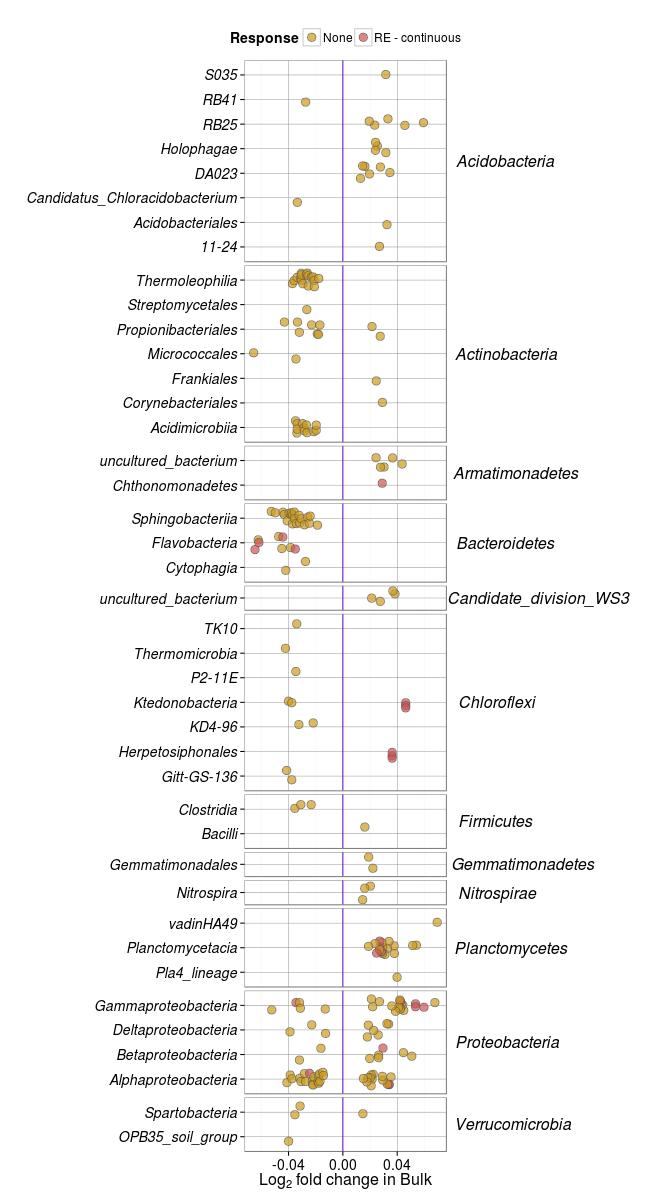

In [33]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p = ggplot(d, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p = p + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p = p + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p = p + geom_vline(xintercept = 0, color = "#751BEA")

p = p + scale_fill_manual(values=colours, na.value = "black")

p = p + theme_bw()

p = p + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p = p + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p

In [15]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.700 = prune_samples((physeq.md$Treatment %in% c("12C700","13C700")) &
                            (physeq.md$Bulk == "1"),
                            physeq) 

physeq.bulk.700 = filter_taxa(physeq.bulk.700, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.700

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6052 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 6052 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6052 tips and 6051 internal nodes ]


In [16]:
%%R
dds2 = phyloseq_to_deseq2(physeq.bulk.700, ~Day)
dds2 = DESeq(dds2, fitType = "local")

r2 = results(dds2, cooksCutoff = FALSE)
r2$OTU = rownames(r2)
r2 = data.frame(r2)

TT2 = data.frame(tax_table(physeq.bulk.700))
TT2$OTU = rownames(TT2)

r2 = left_join(r2, TT2)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 27 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Joining by: "OTU"


In [17]:
%%R
l2fc.time.700 = r2 %>% 
    filter(baseMean > 0)

write.csv(l2fc.time.700, "data/l2fc.700_Wtime_table.csv", row.names = FALSE)

In [18]:
!head data/l2fc.700_Wtime_table.csv | cut -c 1-60

"baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","
0.0807998766533975,0.000925763313062286,0.00638097058805417,
0.0219293240759275,-0.00282024129744472,0.00603128479307853,
0.0807998766533975,0.000925763313062286,0.00638097058805417,
0.097214350931759,-0.00616635568961508,0.00689053137056699,-
0.0219293240759275,-0.00282024129744472,0.00603128479307853,
32.7902906179436,-0.00923611504300747,0.0073300324749052,-1.
16.8764280087137,-0.0146177335680454,0.00750527601723599,-1.
1.9120965924233,-0.0347918634110403,0.0124161790660652,-2.80
3.65328878737022,-0.0383651672760093,0.0110645056284391,-3.4


In [19]:
%%R
FDR = 0.10 

d2 = r2 %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

nrow(d2)

[1] 230


In [20]:
%%R
FDR = 0.10

resp.700 = df.rspnse %>% 
    filter((padj <= FDR),
           (Treatment == "13C700")) 

resp.700$rspnse = as.character("RE - single")
resp.700 = resp.700 %>%
    select(OTU, rspnse)

nrow(resp.700)

[1] 454


In [21]:
%%R
d2 = left_join(d2, resp.700, by = "OTU")
#d2$Treatment = as.character("RE - single")

d2$rspnse[is.na(d2$rspnse)] = "None"
#levels(d$rspnse) = c("Xylose", "Cellulose", "Both", "None")
#d2 = d2 %>%
#    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj, rspnse)
head(d2)

       OTU          Rank2                Rank3           Rank4 log2FoldChange
1  OTU.474 Proteobacteria  Gammaproteobacteria Pseudomonadales    -0.09390819
2 OTU.1343 Proteobacteria  Gammaproteobacteria Pseudomonadales    -0.07140600
3  OTU.584 Proteobacteria  Gammaproteobacteria   Legionellales     0.07008438
4  OTU.452            TM6 uncultured_bacterium            <NA>     0.06641945
5  OTU.433 Proteobacteria  Gammaproteobacteria            NKB5     0.06336675
6  OTU.374  Acidobacteria           Holophagae       43F-1404R     0.06080947
          padj      rspnse
1 2.398608e-11        None
2 9.401499e-06        None
3 9.401499e-06 RE - single
4 6.079028e-05        None
5 1.636486e-04 RE - single
6 1.597567e-05        None


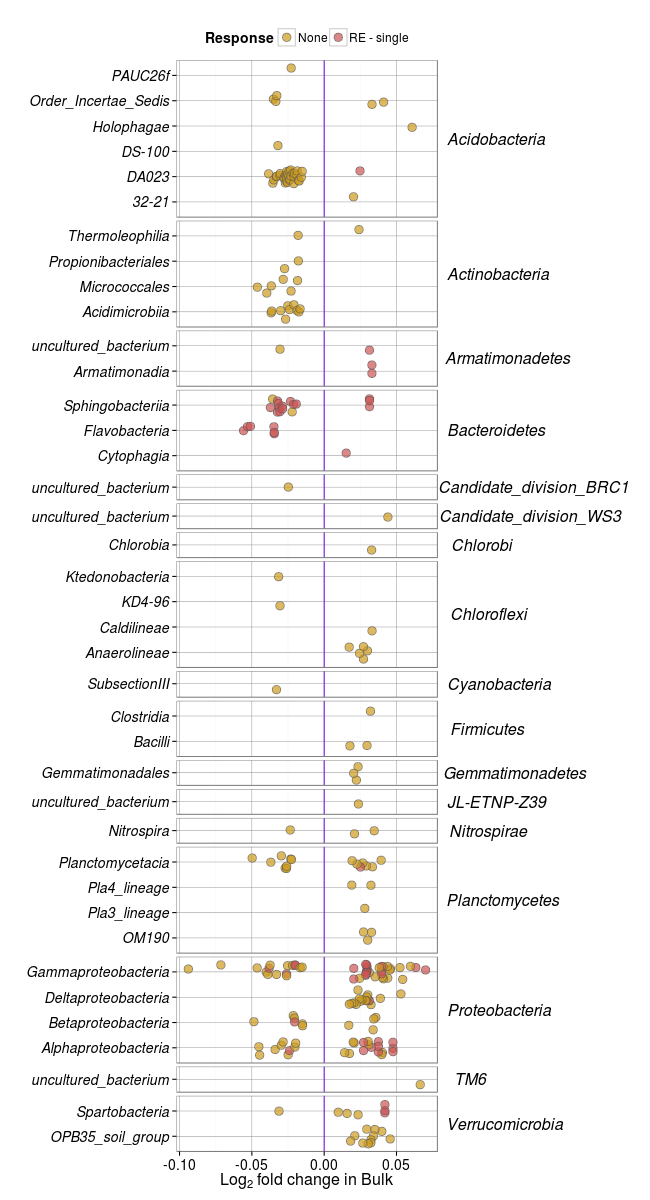

In [32]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p2 = ggplot(d2, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p2 = p2 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p2 = p2 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p2 = p2 + geom_vline(xintercept = 0, color = "#751BEA")

p2 = p2 + scale_fill_manual(values=colours, na.value = "black")

p2 = p2 + theme_bw()

p2 = p2 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p2 = p2 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p2

In [23]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.CC = prune_samples((physeq.md$Treatment %in% c("12CC","13CC")) &
                            (physeq.md$Bulk == "1"),
                            physeq) 

physeq.bulk.CC = filter_taxa(physeq.bulk.CC, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.CC

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6008 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 6008 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6008 tips and 6007 internal nodes ]


In [24]:
%%R
dds3 = phyloseq_to_deseq2(physeq.bulk.CC, ~Day)
dds3 = DESeq(dds3, fitType = "local")

r3 = results(dds3, cooksCutoff = FALSE)
r3$OTU = rownames(r3)
r3 = data.frame(r3)

TT3 = data.frame(tax_table(physeq.bulk.CC))
TT3$OTU = rownames(TT3)

r3 = left_join(r3, TT3)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 8 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Joining by: "OTU"


In [25]:
%%R
l2fc.time.CC = r3 %>% 
    filter(baseMean > 0)

write.csv(l2fc.time.CC, "data/l2fc.CC_Wtime_table.csv", row.names = FALSE)

In [26]:
!head data/l2fc.CC_Wtime_table.csv | cut -c 1-60

"baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","
0.0579027020406244,4.47915862249382e-05,0.00369476102967312,
0.0429320130869977,-0.00262138980531693,0.0036951303219747,-
0.0723840900849091,0.00283456925470182,0.00372794613029707,0
0.0829138538403759,0.00300110836569467,0.003741484842152,0.8
0.0561084762724833,-0.0018484885066136,0.00370689607925407,-
0.101142272651486,-0.00115118464555346,0.00373740890108131,-
0.0280542381362416,-0.00120611853429416,0.00369429301459633,
35.3443494892491,-0.018431253049369,0.00641423090176481,-2.8
15.5534836166911,-0.00957003889646009,0.00663767785360096,-1


In [27]:
%%R
FDR = 0.10 

d3 = r3 %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

nrow(d3)

[1] 176


In [28]:
%%R
FDR = 0.10

resp.CC = df.rspnse %>% 
    filter((padj <= FDR),
           (Treatment == "13CC")) 

resp.CC$rspnse = as.character("Cellulose Only")
resp.CC = resp.CC %>%
    select(OTU, rspnse)

nrow(resp.CC)

[1] 435


In [29]:
%%R
d3 = left_join(d3, resp.CC, by = "OTU")
#d2$Treatment = as.character("RE - single")

d3$rspnse[is.na(d3$rspnse)] = "None"
#levels(d$rspnse) = c("Xylose", "Cellulose", "Both", "None")
#d2 = d2 %>%
#    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj, rspnse)
head(d3)

       OTU          Rank2               Rank3            Rank4 log2FoldChange
1  OTU.318 Proteobacteria Gammaproteobacteria    Legionellales     0.07490696
2  OTU.321 Proteobacteria Gammaproteobacteria    Legionellales     0.05117563
3 OTU.1419  Bacteroidetes       Flavobacteria Flavobacteriales    -0.04431675
4 OTU.1419  Bacteroidetes       Flavobacteria Flavobacteriales    -0.04431675
5  OTU.927 Proteobacteria Deltaproteobacteria     Myxococcales     0.04406985
6  OTU.653 Proteobacteria Deltaproteobacteria     Myxococcales     0.04302321
          padj         rspnse
1 2.533980e-15           None
2 6.969310e-05           None
3 6.588416e-04 Cellulose Only
4 6.588416e-04 Cellulose Only
5 7.596373e-04 Cellulose Only
6 1.296459e-04           None


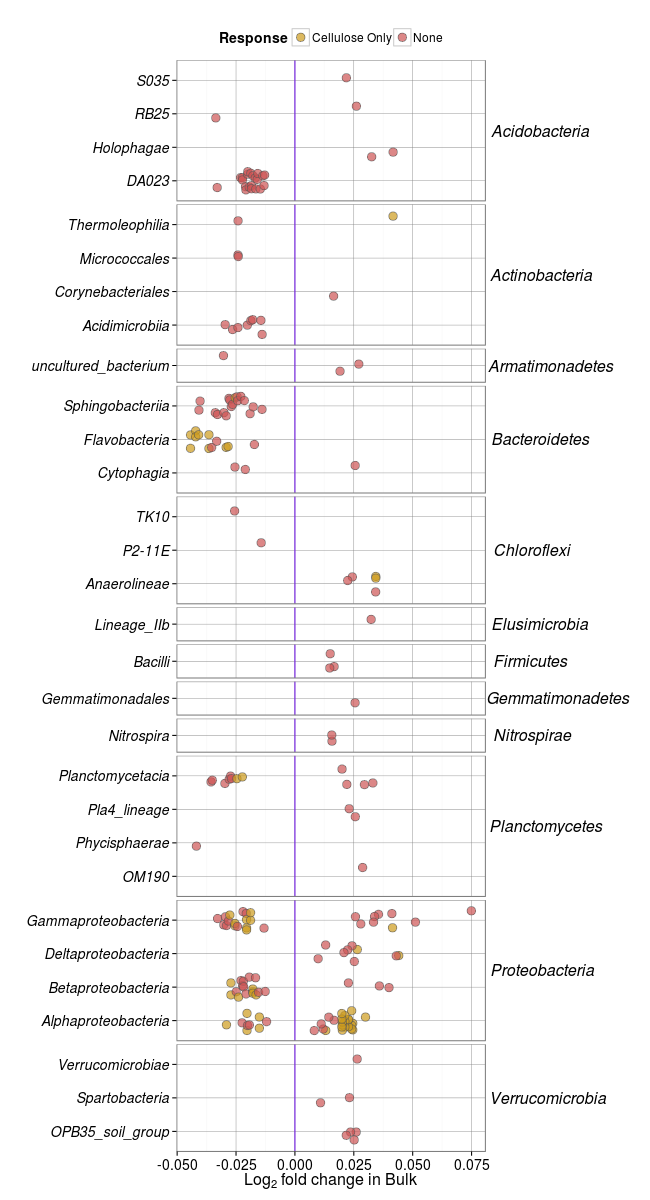

In [31]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p3 = ggplot(d3, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p3 = p3 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p3 = p3 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p3 = p3 + geom_vline(xintercept = 0, color = "#751BEA")

p3 = p3 + scale_fill_manual(values=colours, na.value = "black")

p3 = p3 + theme_bw()

p3 = p3 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p3 = p3 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p3

In [40]:
%%R
l2fc.time = rbind(d, d2, d3)
l2fc.time = l2fc.time %>%
    filter(rspnse %in% c("Cellulose Only", "RE - single", "RE - continuous"))
l2fc.time

          OTU           Rank2                Rank3                Rank4
1    OTU.1171   Bacteroidetes        Flavobacteria     Flavobacteriales
2    OTU.3519   Bacteroidetes        Flavobacteria     Flavobacteriales
3     OTU.144  Proteobacteria  Gammaproteobacteria      Xanthomonadales
4     OTU.109  Proteobacteria  Gammaproteobacteria      Xanthomonadales
5     OTU.109  Proteobacteria  Gammaproteobacteria      Xanthomonadales
6      OTU.50     Chloroflexi      Ktedonobacteria                C0119
7      OTU.50     Chloroflexi      Ktedonobacteria                C0119
8      OTU.50     Chloroflexi      Ktedonobacteria                C0119
9     OTU.336   Bacteroidetes        Flavobacteria     Flavobacteriales
10   OTU.6983  Proteobacteria  Gammaproteobacteria      Xanthomonadales
11   OTU.6983  Proteobacteria  Gammaproteobacteria      Xanthomonadales
12   OTU.6205     Chloroflexi    Herpetosiphonales   Herpetosiphonaceae
13   OTU.6205     Chloroflexi    Herpetosiphonales   Herpetosiph

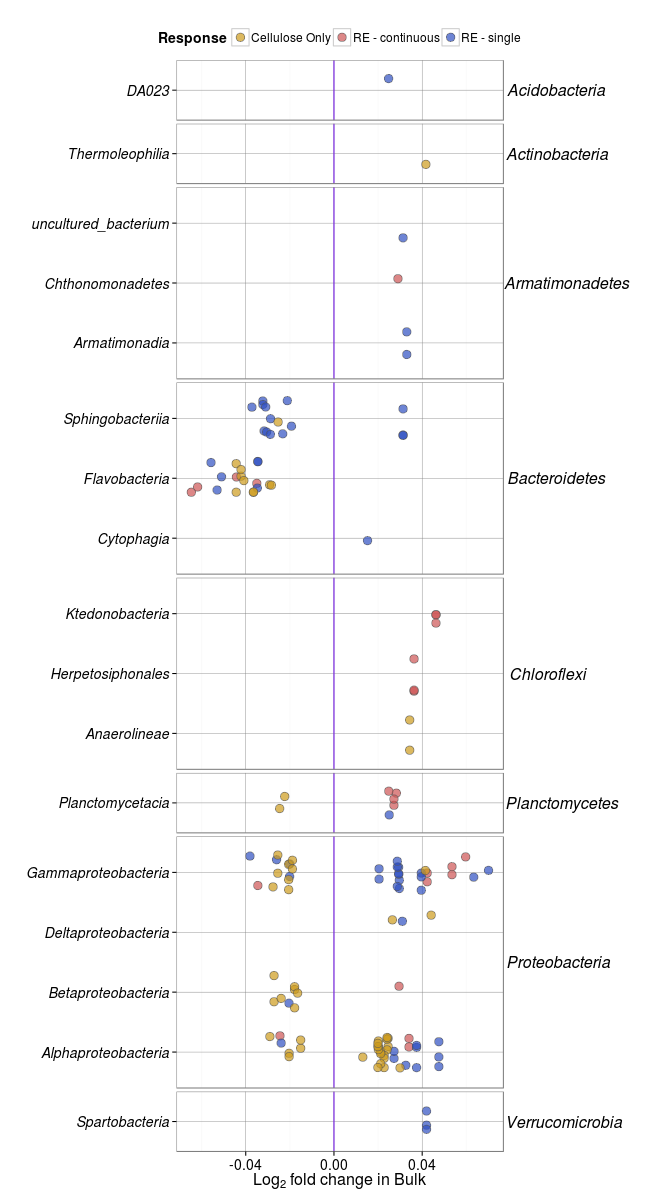

In [41]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1", "black")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p3 = ggplot(l2fc.time, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p3 = p3 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p3 = p3 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p3 = p3 + geom_vline(xintercept = 0, color = "#751BEA")

p3 = p3 + scale_fill_manual(values=colours, na.value = "black")

p3 = p3 + theme_bw()

p3 = p3 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p3 = p3 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p3

In [37]:
%%R
FDR = 0.10

df.rspnse.100 = df.rspnse %>%
    filter(Treatment == "13C100") %>%
    group_by(OTU, Treatment) %>%
    #summarize(min.P = min(padj), 
    #          Rank2 = first(Rank2), 
    #          Rank3 = first(Rank3)) %>%
    filter(padj <= FDR) %>%
    group_by(OTU) %>%
    #summarize(rspnse = rspnse(min.P, Treatment)) %>%
    left_join(df.bulk.100)

df.rspnse.100$Day = as.factor(df.rspnse.100$Day)
df.rspnse.100

Joining by: "OTU"
Source: local data frame [367 x 16]
Groups: OTU

   sparsity_threshold Day Treatment      OTU log2FoldChange            p
1                0.45  14    13C100  OTU.473       2.157713 4.396896e-04
2                0.45  14    13C100 OTU.1248       2.479295 1.889833e-04
3                0.45  14    13C100  OTU.472       2.374421 1.010729e-04
4                0.45  14    13C100  OTU.380       3.430650 2.164432e-08
5                0.45  14    13C100 OTU.2256       2.970281 1.106214e-05
6                0.45  14    13C100   OTU.31       2.472821 8.813668e-04
7                0.45  14    13C100 OTU.8290       2.202850 1.173330e-03
8                0.45  14    13C100 OTU.5674       2.203162 3.141669e-04
9                0.45  14    13C100   OTU.73       1.953566 2.150712e-03
10               0.45  14    13C100 OTU.8167       2.963910 2.996490e-06
..                ... ...       ...      ...            ...          ...
Variables not shown: Rank1 (fctr), Rank2 (fctr), Rank3 (f

NULL


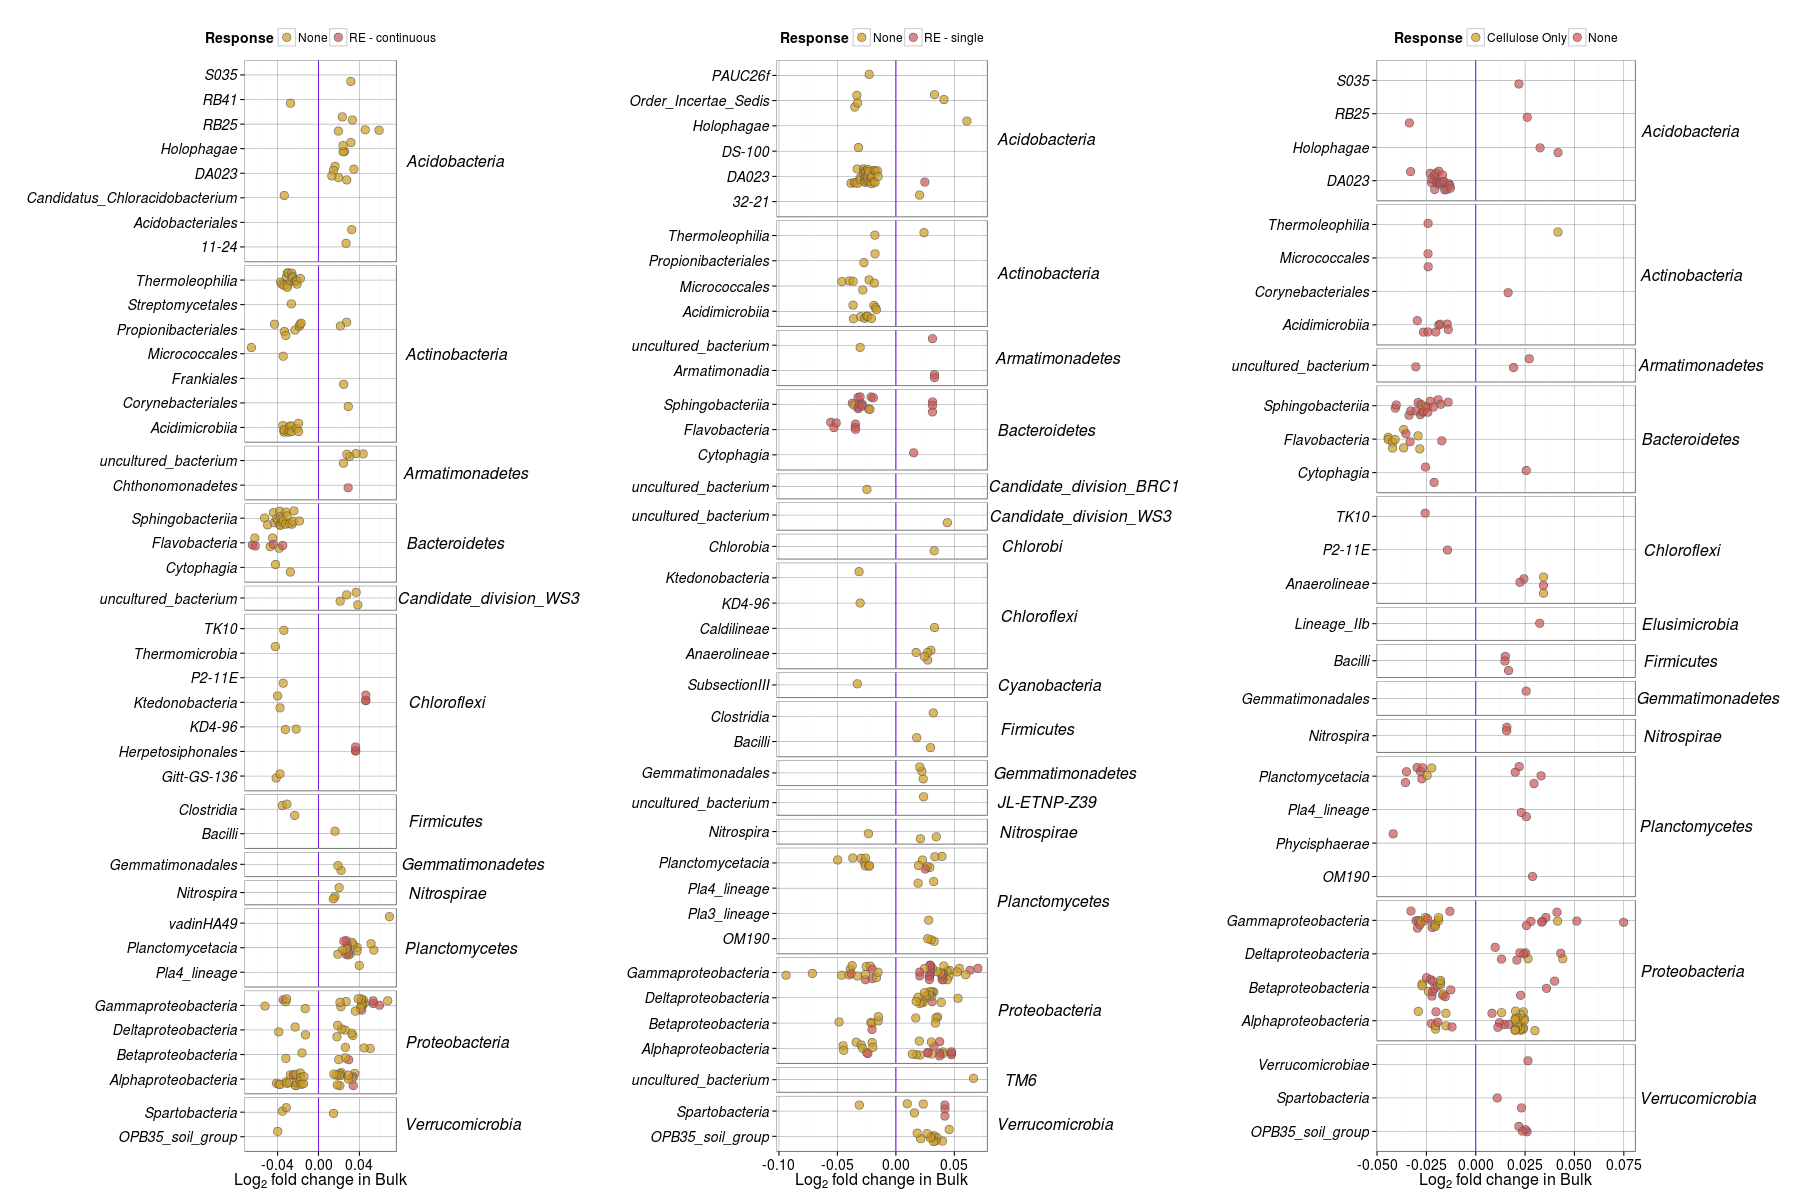

In [34]:
%%R -h 1200 -w 1800
p.combined = grid.arrange(p, p2, p3, ncol = 3)
p.combined

In [26]:
%%R -w 1000 -h 1200
pdf("figs/bulkl2fc_700_byday.pdf", width = 25, height = 17)
grid.arrange(p, p2, p3, ncol=3)
dev.off()

png 
  2 


In [27]:
FileLink("figs/bulkl2fc_700_byday.pdf")

/home/ashley/priming_exp/figs/bulkl2fc_700_byday.pdf

In [28]:
%%R 
png("figs/bulkl2fc_700_byday.png", width = 1900, height = 1600)
grid.arrange(p, p2, p3, ncol=3)
dev.off()

png 
  2 


In [29]:
FileLink("figs/bulkl2fc_700_byday.png")

/home/ashley/priming_exp/figs/bulkl2fc_700_byday.png